# <a style='color:blue'>Anticipez les besoins en consommation de bâtiments (Notebook 3)

- <a href="#C1">1: Préparation des données</a>
    - <a href="#C11">1.1 Imports</a>
    - <a href="#C12">1.2 Séparation des features et de la target</a>
    - <a href="#C13">1.3 Séparation des données en train/test</a>
    - <a href="#C14">1.4 Standardisation des données</a>

- <a href="#C2">2: Modélisation</a>
    - <a href="#C21">2.1 Baseline: régresseur naïf</a>
    - <a href="#C22">2.2 Régression linéaire</a>
    - <a href="#C23">2.3 Régression Ridge</a>
    - <a href="#C24">2.4 ElasticNet</a>
    - <a href="#C25">2.5 SVR linéaire</a>
    - <a href="#C26">2.6 SVR non linéaire</a>
    - <a href="#C27">2.7 GradientBoosting</a>
    - <a href="#C28">2.8 RandomForest</a>
    
- <a href="#C3">3: Comparaison des résultats</a>
    - <a href="#C31">3.1 Choix du modèle</a>
    - <a href="#C32">3.2 Importance des variables globale</a>
    - <a href="#C33">3.3 Importance des variables locale</a>
    
- <a href="#C4">4: Intégration d'Energy Star Score</a>
    - <a href="#C41">4.1 Entrainement du meilleur modèle avec Energy Star Score</a>
    - <a href="#C42">4.2 Comparaison des résultats</a>
    - <a href="#C43">4.3 Importance des variables globale</a>
    

# <a name="C1">Partie 1: Préparation des données</a>

# <a name="C11">1. Imports</a>

In [47]:
# Librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno

# import fichier CSV
buildings=pd.read_csv('buildings_before_modelisation.csv')

# preprocessing
from sklearn import preprocessing

# estimators
from sklearn import dummy
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

# model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

#metrics
from sklearn import metrics
import timeit

# <a name="C12">2. Séparation des features et de la target</a>

**1 - Features**

In [48]:
# Suppression des target1 et target2 et des variables pas utiles pour la modélisation
buildings_X=buildings.drop(columns=['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions', 'ENERGYSTARScore','OSEBuildingID','PrimaryPropertyType','PropertyName','Neighborhood'])

# Transformation du dataframe buildings_X en matrice X
X=buildings_X.values #Transfo en array avec méthode values (as_matrix n'est plus supportée)

X.shape

(1421, 37)

**2 - Target**

In [49]:
# Transformation en array numpy (vecteur Y contenant la variable à prédire)
#Y=buildings.loc[:,'SiteEnergyUseWN(kBtu)'].values #=> target1
Y=buildings.loc[:,'TotalGHGEmissions'].values #=> target2
Y.shape

(1421,)

# <a name="C13">3. Séparation des données en train/test</a>

Séparons nos données en un jeu d’entraînement et un jeu de test. Le jeu de test contiendra 30% des données.

In [50]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = \
	model_selection.train_test_split(X, Y,
                                	test_size=0.30, # 30% des données dans le jeu de test
                                	random_state=42) #permet d'avoir toujours les mêmes jeux de train et de test

# <a name="C14">4. Standardisation des données</a>

In [51]:
# Les données auront toutes une moyenne nulle et un écart type de 1
from sklearn.preprocessing import StandardScaler
std_scale = preprocessing.StandardScaler().fit(X_train) #calcul de la moyenne et l’écart type de X_train
X_train_std = std_scale.transform(X_train) #standardisation de X_train en utilisant la moyenne et l’écart type calculés à partir de X_train.
X_test_std = std_scale.transform(X_test) #standardisation de X_test en utilisant la moyenne et l’écart type calculés à partir de X_train.

# <a name="C2">Partie 2: Modélisation</a>

# <a name="C21">2.1 Baseline: régresseur naïf</a>

Utilisons un régresseur naif pour:
    
    - valider le format des données (compatible avec une modélisation)
    
    - Avoir un score de base à comparer avec ceux de nos futurs modèles

**1 - Entrainement**

Entrainons un dummy regressor qui prédira toujours la moyenne:

In [52]:
# Instanciation
dum = dummy.DummyRegressor(strategy='mean')

# Entraînement
start_time = timeit.default_timer()
dum.fit(X_train_std, y_train)
train_time_dum = timeit.default_timer() - start_time # calcul de la durée de train
print("Train Time Dummy: {:.5f}".format(train_time_dum))

# Prédiction sur le jeu de test
start_time = timeit.default_timer()
y_pred_dum = dum.predict(X_test_std)
test_time_dum = timeit.default_timer() - start_time # calcul de la durée de prédiction
print("Test Time Dummy: {:.5f}".format(test_time_dum))

Train Time Dummy: 0.00055
Test Time Dummy: 0.00021


**2 - Evaluation des performances**

In [53]:
#Calcul de la RMSE (Root Mean Squared Error)
RMSE_dum=np.sqrt(metrics.mean_squared_error(y_test, y_pred_dum))
print("RMSE Dummy: {:.2f}".format(RMSE_dum))

RMSE Dummy: 1.44


In [54]:
# Calcul du coefficient de détermination R²
R2_dum=metrics.r2_score(y_test, y_pred_dum)
print("R2 Dummy: {:.5f}".format(R2_dum))

R2 Dummy: -0.00020


Le coefficient de détermination R² est proche de 0, ce qui est cohérent pour un modèle naif

In [55]:
# Calcul de la MAE (Mean Absolute Error)
MAE_dum = metrics.mean_absolute_error(y_test, y_pred_dum)
print("MAE Dummy: {:.5f}".format(MAE_dum))

MAE Dummy: 1.13379


# <a name="C22">2.2 Régression linéaire</a>

**1 - Entrainement**

In [56]:
# Instanciation
reg = LinearRegression()

# Entraînement
start_time = timeit.default_timer()
reg.fit(X_train_std, y_train)
train_time_reg = timeit.default_timer() - start_time # calcul de la durée de train
print("Train Time Linear Regression: {:.5f}".format(train_time_reg))

# Prédiction sur le jeu de test
start_time = timeit.default_timer()
y_pred_reg = reg.predict(X_test_std)
test_time_reg = timeit.default_timer() - start_time # calcul de la durée de prédiction
print("Test Time Linear Regression: {:.5f}".format(test_time_reg))

Train Time Linear Regression: 0.00177
Test Time Linear Regression: 0.00028


**2 - Evaluation des performances**

In [57]:
#Calcul de la RMSE
RMSE_reg=np.sqrt(metrics.mean_squared_error(y_test, y_pred_reg))
print("RMSE Linear Regression: {:.2f}".format(RMSE_reg))

RMSE Linear Regression: 0.84


In [58]:
# Calcul du coefficient de détermination R²
R2_reg=metrics.r2_score(y_test, y_pred_reg)
print("R2 Linear Regression: {:.2f}".format(R2_reg))

R2 Linear Regression: 0.66


In [59]:
# Calcul de la MAE
MAE_reg = metrics.mean_absolute_error(y_test, y_pred_reg)
print("MAE Linear Regression: {:.2f}".format(MAE_reg))

MAE Linear Regression: 0.65


# <a name="C23">2.3 Régression Ridge</a>

La régression ridge est une technique de régularisation qui permet d'éviter le surapprentissage en restraignant l'amplitude de certains poids.

- Diminution de l'erreur standard en biaisant la prédiction

- Rechercher du coefficient de régularisation alpha optimal

**1 - Optimisation des hyperparamètres avec GridSearchCV**

- Validation croisée sur le jeu de train (divisé en sous jeux train/test) pour optimiser les hyperparametres.

- Le jeu de test sert à valider le modèle une fois les hyperparametres optimisés

L'hyperparamètre Alpha est compris entre [0, inf) et par défaut=1

- Alpha= Constante x L2 term (controlling regularization strength)

- Alpha=0 revient à faire une régression linéaire

- Choisissons de 200 valeurs de Alpha entre 0.00001 et 10000

In [14]:
# Instanciation du modèle Ridge
estimator=Ridge()

# Liste des hyperparamètres à tester
alphas = np.logspace(-5, 5, 200) #
param_grid={'alpha': alphas}

grid=GridSearchCV(estimator, param_grid, cv=10, return_train_score=True,verbose=1)


In [15]:
# Entrainement du GridSearchCV
grid.fit(X_train_std, y_train)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


GridSearchCV(cv=10, estimator=Ridge(),
             param_grid={'alpha': array([1.00000000e-05, 1.12266777e-05, 1.26038293e-05, 1.41499130e-05,
       1.58856513e-05, 1.78343088e-05, 2.00220037e-05, 2.24780583e-05,
       2.52353917e-05, 2.83309610e-05, 3.18062569e-05, 3.57078596e-05,
       4.00880633e-05, 4.50055768e-05, 5.05263107e-05, 5.67242607e-05,
       6.36824994e-05, 7.14942899e-05, 8.02643352e-05, 9...
       6.98587975e+03, 7.84282206e+03, 8.80488358e+03, 9.88495905e+03,
       1.10975250e+04, 1.24588336e+04, 1.39871310e+04, 1.57029012e+04,
       1.76291412e+04, 1.97916687e+04, 2.22194686e+04, 2.49450814e+04,
       2.80050389e+04, 3.14403547e+04, 3.52970730e+04, 3.96268864e+04,
       4.44878283e+04, 4.99450512e+04, 5.60716994e+04, 6.29498899e+04,
       7.06718127e+04, 7.93409667e+04, 8.90735464e+04, 1.00000000e+05])},
             return_train_score=True, verbose=1)

In [16]:
# Affichage des meilleurs hyperparamètres
best_params=grid.best_params_
best_params

{'alpha': 17.027691722259014}

In [17]:
# Fonction qui récupère, filtre les colonnes et classe par "rank_test_score"
def resultize(grid) :
    res=pd.DataFrame(grid.cv_results_) #Récupération des résultats du gridserachCV et stockage dans un dataframe res 
    cols=[i for i in res.columns if "split" not in i] #Filtrage des colonnes (ne contiennent pas "split")
    res=res[cols] 
    res=res.sort_values('rank_test_score') #classement en fonction du "rank_test_score"
    return res[:10]



In [18]:
resultize(grid)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
124,0.000000,0.000000,0.000000,0.000000,17.027692,{'alpha': 17.027691722259014},0.677663,0.049558,1,0.709209,0.004929
125,0.000000,0.000000,0.000000,0.000000,19.116441,{'alpha': 19.116440753857038},0.677662,0.049541,2,0.709153,0.004929
123,0.000000,0.000000,0.000000,0.000000,15.167169,{'alpha': 15.167168884709241},0.677657,0.049575,3,0.709253,0.004929
126,0.000000,0.000000,0.000000,0.000000,21.461412,{'alpha': 21.461411978584056},0.677653,0.049522,4,0.709084,0.004930
122,0.001563,0.004688,0.000000,0.000000,13.509935,{'alpha': 13.50993521198028},0.677648,0.049591,5,0.709289,0.004928
121,0.001563,0.004688,0.000000,0.000000,12.033778,{'alpha': 12.033778407775905},0.677635,0.049606,6,0.709318,0.004928
127,0.000254,0.000409,0.000102,0.000305,24.094036,{'alpha': 24.09403560239527},0.677633,0.049503,7,0.708998,0.004931
120,0.000000,0.000000,0.001563,0.004688,10.718913,{'alpha': 10.718913192051286},0.677621,0.049619,8,0.709341,0.004928
119,0.000000,0.000000,0.001563,0.004688,9.547716,{'alpha': 9.547716114208066},0.677605,0.049632,9,0.709359,0.004928
128,0.000000,0.000000,0.000000,0.000000,27.049597,{'alpha': 27.04959730463137},0.677598,0.049484,10,0.708891,0.004932


**2 - Ré-entrainement du modèle avec les meilleurs hyperparamètres (sur l'ensemble du jeu de train)**

In [19]:
# Instanciation du modèle Ridge avec les meilleurs hyperparamètres 
ridge = Ridge(**best_params)
ridge

Ridge(alpha=17.027691722259014)

In [20]:
# Ré-entrainement du modèle Ridge sur l'ensemble du jeu de train (on ne fait plus de fold) et calcul du temps d'entrainement
start_time = timeit.default_timer()
ridge.fit(X_train_std, y_train)
train_time_ridge = timeit.default_timer() - start_time
print("Train Time Ridge Regression: {:.4f}".format(train_time_ridge))

# Calcul du vecteur et de la durée de prédiction 
start_time = timeit.default_timer()
y_pred_ridge = ridge.predict(X_test_std)
test_time_ridge = timeit.default_timer() - start_time
print("Test Time Ridge Regression: {:.4f}".format(test_time_ridge))

Train Time Ridge Regression: 0.0015
Test Time Ridge Regression: 0.0003


**3 - Calcul des scores après ré-entrainement avec les meilleurs hyperparamètres**

In [21]:
#Calcul de la RMSE
RMSE_ridge=np.sqrt( metrics.mean_squared_error(y_test, y_pred_ridge) )
print("RMSE Ridge: {:.2f}".format(RMSE_ridge))

RMSE Ridge: 0.84


In [22]:
# Calcul du coefficient de détermination R²
R2_ridge = metrics.r2_score(y_test, y_pred_ridge)
print("R2 Ridge: {:.2f}".format(R2_ridge))

R2 Ridge: 0.66


In [23]:
# Calcul de la MAE
MAE_ridge = metrics.mean_absolute_error(y_test, y_pred_ridge)
print("MAE Ridge: {:.2f}".format(MAE_ridge))

MAE Ridge: 0.65


# <a name="C24">2.4 ElasticNet</a>

ElasticNet est également un modèle linéaire.

Il combine les techniques de régularisations L1 et L2 du Lasso et de la régression Ridge

Il est utile quand plusieurs features sont corrélées

**1 - Optimisation des hyperparamètres avec GridSearchCV**

- **Alpha**: paramètre de régularisation qui contrôle la force de la pénalité L1 et L2. Il doit être un nombre positif. Plus la valeur d’alpha est élevée, plus la régularisation est forte. Les valeurs possibles pour alpha sont généralement choisies dans une plage logarithmique, par exemple, [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000].

- **l1_ratio**: paramètre qui contrôle le mélange de la pénalité L1 et L2. Il doit être compris entre 0 et 1** Lorsque l1_ratio = 1, la pénalité est L1. Lorsque l1_ratio = 0, la pénalité est L2

In [24]:
# Instanciation du modèle ElasticNet
estimator=ElasticNet()

# hyperparamètres à tester
l1_ratios = [0.1, 0.3, 0.5, 0.7, 0.9] #Les valeurs possibles pour l1_ratio sont généralement choisies dans une plage linéaire
alphas = np.logspace(-5, 5, 50) #10 valeurs entre 10e-5 et 100000
param_grid={'alpha': alphas, 'l1_ratio': l1_ratios}

grid=GridSearchCV(estimator, param_grid, cv=10, return_train_score=True,verbose=1)

In [25]:
# Entrainement du GridSearchCV
grid.fit(X_train_std, y_train)

Fitting 10 folds for each of 250 candidates, totalling 2500 fits


C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.315e+01, tolerance: 1.834e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.779e+01, tolerance: 1.807e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or co

C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.479e+01, tolerance: 1.783e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.485e+01, tolerance: 1.835e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or co

C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.260e+01, tolerance: 1.834e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.574e+01, tolerance: 1.807e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or co

C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.440e+01, tolerance: 1.783e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.291e+01, tolerance: 1.835e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or co

C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.174e+01, tolerance: 1.834e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.496e+01, tolerance: 1.807e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or co

C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.231e+01, tolerance: 1.835e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.801e+01, tolerance: 1.822e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or co

C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.419e+01, tolerance: 1.813e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.928e+01, tolerance: 1.787e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or co

C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.687e+01, tolerance: 1.834e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.641e+01, tolerance: 1.807e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or co

C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.671e+01, tolerance: 1.835e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.794e+01, tolerance: 1.822e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or co

C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.618e+00, tolerance: 1.813e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.557e+00, tolerance: 1.787e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or co

C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.059e+01, tolerance: 1.834e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.117e+01, tolerance: 1.807e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or co

C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.720e-01, tolerance: 1.838e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.490e+00, tolerance: 1.808e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or co

C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.434e+00, tolerance: 1.822e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.217e+01, tolerance: 1.838e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or co

C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.247e+01, tolerance: 1.807e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.576e+01, tolerance: 1.818e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or co

C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.321e+00, tolerance: 1.813e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.368e+00, tolerance: 1.787e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or co

C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.077e+00, tolerance: 1.808e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.316e+00, tolerance: 1.808e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or co

GridSearchCV(cv=10, estimator=ElasticNet(),
             param_grid={'alpha': array([1.00000000e-05, 1.59985872e-05, 2.55954792e-05, 4.09491506e-05,
       6.55128557e-05, 1.04811313e-04, 1.67683294e-04, 2.68269580e-04,
       4.29193426e-04, 6.86648845e-04, 1.09854114e-03, 1.75751062e-03,
       2.81176870e-03, 4.49843267e-03, 7.19685673e-03, 1.15139540e-02,
       1.84206997e-02, 2.94705170e-02, 4.71486636e...
       5.17947468e+00, 8.28642773e+00, 1.32571137e+01, 2.12095089e+01,
       3.39322177e+01, 5.42867544e+01, 8.68511374e+01, 1.38949549e+02,
       2.22299648e+02, 3.55648031e+02, 5.68986603e+02, 9.10298178e+02,
       1.45634848e+03, 2.32995181e+03, 3.72759372e+03, 5.96362332e+03,
       9.54095476e+03, 1.52641797e+04, 2.44205309e+04, 3.90693994e+04,
       6.25055193e+04, 1.00000000e+05]),
                         'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]},
             return_train_score=True, verbose=1)

In [26]:
# Affichage des meilleurs hyperparamètres
best_params=grid.best_params_
best_params

{'alpha': 0.018420699693267165, 'l1_ratio': 0.7}

In [27]:
resultize(grid)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_l1_ratio,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
83,0.001563,0.004688,0.000000,0.000000,0.018421,0.7,"{'alpha': 0.018420699693267165, 'l1_ratio': 0.7}",0.679768,0.052092,1,0.707057,0.004906
79,0.000000,0.000000,0.000000,0.000000,0.011514,0.9,"{'alpha': 0.011513953993264481, 'l1_ratio': 0.9}",0.679722,0.051671,2,0.707899,0.004924
82,0.000000,0.000000,0.001563,0.004688,0.018421,0.5,"{'alpha': 0.018420699693267165, 'l1_ratio': 0.5}",0.679707,0.051390,3,0.707955,0.004925
86,0.000000,0.000000,0.000000,0.000000,0.029471,0.3,"{'alpha': 0.029470517025518096, 'l1_ratio': 0.3}",0.679596,0.051216,4,0.707633,0.004920
78,0.001875,0.004607,0.000000,0.000000,0.011514,0.7,"{'alpha': 0.011513953993264481, 'l1_ratio': 0.7}",0.679585,0.051211,5,0.708397,0.004928
84,0.000000,0.000000,0.001563,0.004688,0.018421,0.9,"{'alpha': 0.018420699693267165, 'l1_ratio': 0.9}",0.679519,0.052667,6,0.705987,0.004879
87,0.001563,0.004688,0.000000,0.000000,0.029471,0.5,"{'alpha': 0.029470517025518096, 'l1_ratio': 0.5}",0.679469,0.052314,7,0.706110,0.004899
74,0.000000,0.000000,0.000000,0.000000,0.007197,0.9,"{'alpha': 0.0071968567300115215, 'l1_ratio': 0.9}",0.679305,0.050938,8,0.708780,0.004923
81,0.000000,0.000000,0.000000,0.000000,0.018421,0.3,"{'alpha': 0.018420699693267165, 'l1_ratio': 0.3}",0.679285,0.050650,9,0.708655,0.004926
77,0.001563,0.004688,0.000000,0.000000,0.011514,0.5,"{'alpha': 0.011513953993264481, 'l1_ratio': 0.5}",0.679256,0.050759,10,0.708801,0.004923


**2 - Ré-entrainement du modèle avec les meilleurs hyperparamètres (sur l'ensemble du jeu de train)**

In [28]:
# Instanciation du modèle ElasticNet avec les meilleurs hyperparamètres 
elasticnet = ElasticNet(**best_params)
elasticnet

ElasticNet(alpha=0.018420699693267165, l1_ratio=0.7)

In [29]:
# Ré-entrainement du modèle ElasticNet sur l'ensemble du jeu de train (on ne fait plus de fold) et calcul du temps d'entrainement
start_time = timeit.default_timer()
elasticnet.fit(X_train_std, y_train)
train_time_elast = timeit.default_timer() - start_time
print("Train Time ElasticNet : {:.4f}".format(train_time_elast))

# Calcul du vecteur de prédiction et du temps de prédiction 
start_time = timeit.default_timer()
y_pred_elast=elasticnet.predict(X_test_std)
test_time_elast = timeit.default_timer() - start_time
print("Test Time ElasticNet : {:.4f}".format(test_time_elast))

Train Time ElasticNet : 0.0015
Test Time ElasticNet : 0.0003


**3 - Calcul des scores après ré-entrainement avec les meilleurs hyperparamètres**

In [30]:
#Calcul de la RMSE
RMSE_elast=np.sqrt( metrics.mean_squared_error(y_test, y_pred_elast) )
print("RMSE ElasticNet: {:.2f}".format(RMSE_elast))

RMSE ElasticNet: 0.83


In [31]:
# Calcul du coefficient de détermination R²
R2_elast = metrics.r2_score(y_test, y_pred_elast)
print("R2 ElasticNet: {:.2f}".format(R2_elast))

R2 ElasticNet: 0.67


In [32]:
# Calcul de la MAE
MAE_elast = metrics.mean_absolute_error(y_test, y_pred_elast)
print("MAE ElasticNet: {:.2f}".format(MAE_elast))

MAE ElasticNet: 0.65


# <a name="C25">2.5 SVR linéaire</a>

**1 - Optimisation des hyperparamètres avec GridSearchCV**

- **C**: paramètre de régularisation, valeur par défaut=1.0. C >0 Le poids de la régularisation est inversement proportionnel à C

In [33]:
# Instanciation du modèle SVR
estimator=LinearSVR()

# Hyperparamètre à tester
Cs = np.logspace(-5, 5, 20)
param_grid={'C':  Cs}

grid=GridSearchCV(estimator, param_grid, cv=10, return_train_score=True,verbose=1)

In [34]:
# Entrainement du GridSearchCV
grid.fit(X_train_std, y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress th

C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\svm\_base.py:1242: Conver

C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\svm\_base.py:1242: Conver

C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\svm\_base.py:1242: Conver

C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\svm\_base.py:1242: Conver

C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\svm\_base.py:1242: Conver

C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\svm\_base.py:1242: Conver

GridSearchCV(cv=10, estimator=LinearSVR(),
             param_grid={'C': array([1.00000000e-05, 3.35981829e-05, 1.12883789e-04, 3.79269019e-04,
       1.27427499e-03, 4.28133240e-03, 1.43844989e-02, 4.83293024e-02,
       1.62377674e-01, 5.45559478e-01, 1.83298071e+00, 6.15848211e+00,
       2.06913808e+01, 6.95192796e+01, 2.33572147e+02, 7.84759970e+02,
       2.63665090e+03, 8.85866790e+03, 2.97635144e+04, 1.00000000e+05])},
             return_train_score=True, verbose=1)

In [35]:
# Affichage des meilleurs hyperparamètres
best_params=grid.best_params_
best_params

{'C': 0.5455594781168515}

In [36]:
resultize(grid)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
9,0.016146,0.007774,0.000335,0.000518,0.545559,{'C': 0.5455594781168515},0.651913,0.054885,1,0.701503,0.004926
8,0.007896,0.005040,0.000350,0.000450,0.162378,{'C': 0.1623776739188721},0.651308,0.056210,2,0.700864,0.005030
10,0.027677,0.007390,0.000131,0.000394,1.832981,{'C': 1.8329807108324339},0.650576,0.055311,3,0.700670,0.004355
7,0.001563,0.004688,0.000000,0.000000,0.048329,{'C': 0.04832930238571752},0.649133,0.059113,4,0.695054,0.005896
11,0.046660,0.009060,0.000100,0.000300,6.158482,{'C': 6.1584821106602545},0.638153,0.051372,5,0.692700,0.006230
6,0.000000,0.000000,0.000000,0.000000,0.014384,{'C': 0.01438449888287663},0.607148,0.066151,6,0.653262,0.007481
12,0.053210,0.006236,0.000300,0.000458,20.691381,{'C': 20.6913808111479},0.586299,0.054799,7,0.631261,0.014096
13,0.057011,0.008008,0.000200,0.000400,69.51928,{'C': 69.51927961775606},0.415159,0.175733,8,0.460704,0.122081
17,0.056247,0.009696,0.000100,0.000300,8858.667904,{'C': 8858.667904100832},0.357225,0.153151,9,0.426855,0.106594
15,0.055845,0.009006,0.000300,0.000459,784.75997,{'C': 784.7599703514607},0.322228,0.107162,10,0.371313,0.088129


**2 - Ré-entrainement du modèle avec les meilleurs hyperparamètres (sur l'ensemble du jeu de train)**

In [37]:
# Instanciation du modèle LinearSVR avec les meilleurs hyperparamètres 
LinearSVR = LinearSVR(**best_params)
LinearSVR

LinearSVR(C=0.5455594781168515)

In [38]:
# Ré-entrainement du modèle LinearSVR sur l'ensemble du jeu de train (on ne fait plus de fold) et calcul du temps d'entrainement
start_time = timeit.default_timer()
LinearSVR.fit(X_train_std, y_train)
train_time_linSVR = timeit.default_timer() - start_time
print("Train Time LinearSVR: {:.4f}".format(train_time_linSVR))

# Calcul du vecteur de prédiction et du temps de prédiction 
start_time = timeit.default_timer()
y_pred_linSVR=LinearSVR.predict(X_test_std)
test_time_linSVR = timeit.default_timer() - start_time
print("Test Time LinearSVR: {:.4f}".format(test_time_linSVR))

Train Time LinearSVR: 0.0176
Test Time LinearSVR: 0.0004


C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\Vincent-Formation\.conda\envs\Projet3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


**3 - Calcul des scores après ré-entrainement avec les meilleurs hyperparamètres**

In [39]:
#Calcul de la RMSE
RMSE_linSVR=np.sqrt( metrics.mean_squared_error(y_test, y_pred_linSVR) )
print("RMSE LinearSVR : {:.2f}".format(RMSE_linSVR))

RMSE LinearSVR : 0.84


In [40]:
# Calcul du coefficient de détermination R²
R2_linSVR = metrics.r2_score(y_test, y_pred_linSVR)
print("R2 LinearSVR: {:.2f}".format(R2_linSVR))

R2 LinearSVR: 0.66


In [41]:
# Calcul de la MAE
MAE_linSVR = metrics.mean_absolute_error(y_test, y_pred_linSVR)
print("MAE LinearSVR: {:.2f}".format(MAE_linSVR))

MAE LinearSVR: 0.65


# <a name="C26">2.6 SVR non linéaire</a>

**1 - Optimisation des hyperparamètres avec GridSearchCV**

- C:  paramètre de régularisation, valeur par défaut=1.0. C >0 Le poids de la régularisation est inversement proportionnel à C

- Epsilon: Paramètre de tolérance. Il définit la marge d’erreur tolérée entre les prévisions et les étiquettes réelles. Plus la valeur d’epsilon est élevée, plus la marge d’erreur tolérée est grande.

In [60]:
# Instanciation
estimator = SVR()

# Liste des hyperparamètres à tester
Cs=np.logspace(-5, 5, 5)
epsilons=np.logspace(-5, 0, 5)
param_grid={'C':  Cs, 'epsilon': epsilons}

grid=GridSearchCV(estimator, param_grid, cv=10, return_train_score=True,verbose=1)

In [61]:
# Entrainement du GridSearchCV
grid.fit(X_train_std, y_train)

Fitting 10 folds for each of 25 candidates, totalling 250 fits


GridSearchCV(cv=10, estimator=SVR(),
             param_grid={'C': array([1.00000000e-05, 3.16227766e-03, 1.00000000e+00, 3.16227766e+02,
       1.00000000e+05]),
                         'epsilon': array([1.00000000e-05, 1.77827941e-04, 3.16227766e-03, 5.62341325e-02,
       1.00000000e+00])},
             return_train_score=True, verbose=1)

In [62]:
# Affichage des meilleurs hyperparamètres
best_params=grid.best_params_
best_params

{'C': 1.0, 'epsilon': 0.05623413251903491}

In [63]:
resultize(grid)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_epsilon,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
13,0.035940,0.007161,0.005082,0.007829,1.0,0.056234,"{'C': 1.0, 'epsilon': 0.05623413251903491}",0.621407,0.048325,1,0.752042,0.003415
12,0.037229,0.007159,0.006251,0.007656,1.0,0.003162,"{'C': 1.0, 'epsilon': 0.0031622776601683794}",0.619669,0.046650,2,0.750697,0.003485
10,0.037503,0.007656,0.006251,0.007656,1.0,0.00001,"{'C': 1.0, 'epsilon': 1e-05}",0.619590,0.046505,3,0.750628,0.003490
11,0.037502,0.007655,0.004847,0.007415,1.0,0.000178,"{'C': 1.0, 'epsilon': 0.00017782794100389227}",0.619586,0.046517,4,0.750630,0.003490
14,0.010938,0.007161,0.001563,0.004688,1.0,1.0,"{'C': 1.0, 'epsilon': 1.0}",0.598030,0.053281,5,0.702301,0.004301
19,0.025002,0.007656,0.000000,0.000000,316.227766,1.0,"{'C': 316.22776601683796, 'epsilon': 1.0}",0.564911,0.059717,6,0.759846,0.004091
18,0.187034,0.015152,0.003125,0.006250,316.227766,0.056234,"{'C': 316.22776601683796, 'epsilon': 0.0562341...",0.389577,0.108460,7,0.904623,0.003208
17,0.235095,0.020253,0.003125,0.006250,316.227766,0.003162,"{'C': 316.22776601683796, 'epsilon': 0.0031622...",0.360559,0.115865,8,0.902089,0.003244
16,0.278144,0.020730,0.003376,0.006170,316.227766,0.000178,"{'C': 316.22776601683796, 'epsilon': 0.0001778...",0.358781,0.116262,9,0.901880,0.003234
15,0.287100,0.023297,0.006251,0.007656,316.227766,0.00001,"{'C': 316.22776601683796, 'epsilon': 1e-05}",0.358686,0.116300,10,0.901869,0.003233


**2 - Ré-entrainement du modèle avec les meilleurs hyperparamètres (sur l'ensemble du jeu de train)**

In [64]:
# Instanciation du modèle NonLinearSVR avec les meilleurs hyperparamètres 
NonLinearSVR = SVR(**best_params)
NonLinearSVR

SVR(epsilon=0.05623413251903491)

In [65]:
# Ré-entrainement du modèle NonLinearSVR sur l'ensemble du jeu de train (on ne fait plus de fold) et calcul du temps d'entrainement
start_time = timeit.default_timer()
NonLinearSVR.fit(X_train_std, y_train)
train_time_nonlinSVR = timeit.default_timer() - start_time
print("Train Time NonLinearSVR: {:.4f}".format(train_time_nonlinSVR))

# Calcul du vecteur de prédiction et du temps de prédiction 
start_time = timeit.default_timer()
y_pred_nonlinSVR=NonLinearSVR.predict(X_test_std)
test_time_nonlinSVR = timeit.default_timer() - start_time
print("Test Time NonLinearSVR: {:.4f}".format(test_time_nonlinSVR))

Train Time NonLinearSVR: 0.0448
Test Time NonLinearSVR: 0.0279


**3 - Calcul des scores après ré-entrainement avec les meilleurs hyperparamètres**

In [66]:
# Calcul de la RMSE
RMSE_nonlinSVR=np.sqrt( metrics.mean_squared_error(y_test, y_pred_nonlinSVR) )
print("RMSE NonLinearSVR: {:.2f}".format(RMSE_nonlinSVR))

RMSE NonLinearSVR: 0.92


In [67]:
# Calcul du coefficient de détermination R²
R2_nonlinSVR = metrics.r2_score(y_test, y_pred_nonlinSVR)
print("R2 NonLinearSVR: {:.2f}".format(R2_nonlinSVR))

R2 NonLinearSVR: 0.59


In [68]:
# Calcul de la MAE
MAE_nonlinSVR = metrics.mean_absolute_error(y_test, y_pred_nonlinSVR)
print("MAE NonLinearSVR: {:.2f}".format(MAE_nonlinSVR))

MAE NonLinearSVR: 0.69


# <a name="C27">2.7 GradientBoosting</a>

Le gradient boosting est un algorithme qui overfit relativement rapidement. On a donc besoin de méthodes de régularisation, qui pénalisent différentes parties de l’algorithme en permettant ainsi de réduire l’overfitting global.

Les hyperparamètres à optimiser sont:
    
- **Learning_rate** qui permet le shrinkage pour la régularisation

- **n_estimators**: nombre d'arbres à utiliser

**1 - Optimisation des hyperparamètres avec GridSearchCV**

In [73]:
estimator = GradientBoostingRegressor()

# Liste des hyperparamètres à tester
param_grid={'n_estimators':  [2000, 3000, 4000, 5000], 'learning_rate': [0.001, 0.002, 0.003, 0.004]}

grid=GridSearchCV(estimator, param_grid, cv=10, return_train_score=True,verbose=1)

In [74]:
# Entrainement du GridSearchCV
grid.fit(X_train_std, y_train)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


GridSearchCV(cv=10, estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.001, 0.002, 0.003, 0.004],
                         'n_estimators': [2000, 3000, 4000, 5000]},
             return_train_score=True, verbose=1)

In [75]:
# Affichage des meilleurs hyperparamètres
best_params=grid.best_params_
best_params

{'learning_rate': 0.003, 'n_estimators': 5000}

In [76]:
resultize(grid)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
11,6.314016,0.024411,0.005450,0.000679,0.003,5000,"{'learning_rate': 0.003, 'n_estimators': 5000}",0.695968,0.049143,1,0.819840,0.003573
13,3.820350,0.035446,0.003419,0.000431,0.004,3000,"{'learning_rate': 0.004, 'n_estimators': 3000}",0.695870,0.049669,2,0.806903,0.003706
10,5.071400,0.028673,0.004244,0.000672,0.003,4000,"{'learning_rate': 0.003, 'n_estimators': 4000}",0.695761,0.049389,3,0.806880,0.003728
14,5.063108,0.023840,0.004403,0.000420,0.004,4000,"{'learning_rate': 0.004, 'n_estimators': 4000}",0.695733,0.049383,4,0.824021,0.003806
7,6.384189,0.040738,0.005424,0.000944,0.002,5000,"{'learning_rate': 0.002, 'n_estimators': 5000}",0.694638,0.049184,5,0.797298,0.003748
9,3.788610,0.013831,0.003539,0.000816,0.003,3000,"{'learning_rate': 0.003, 'n_estimators': 3000}",0.693484,0.049131,6,0.792143,0.003842
15,6.315643,0.045869,0.005297,0.000558,0.004,5000,"{'learning_rate': 0.004, 'n_estimators': 5000}",0.693163,0.049379,7,0.839472,0.004312
12,2.551113,0.014607,0.002486,0.000495,0.004,2000,"{'learning_rate': 0.004, 'n_estimators': 2000}",0.691626,0.049998,8,0.786300,0.003848
6,5.052353,0.059430,0.004192,0.000375,0.002,4000,"{'learning_rate': 0.002, 'n_estimators': 4000}",0.691585,0.049763,9,0.786193,0.003978
5,3.781003,0.022427,0.003320,0.000820,0.002,3000,"{'learning_rate': 0.002, 'n_estimators': 3000}",0.682418,0.051313,10,0.769791,0.003921


**2 - Ré-entrainement du modèle avec les meilleurs hyperparamètres (sur l'ensemble du jeu de train)**

In [79]:
# Instanciation du modèle GradientBoostingRegressor avec les meilleurs hyperparamètres 
GradientBoost = GradientBoostingRegressor(**best_params)
GradientBoost

GradientBoostingRegressor(learning_rate=0.003, n_estimators=5000)

**Meilleurs hyperparamètres: learning_rate=0.003 et n_estimators=5000**

In [84]:
# Ré-entrainement du modèle GradientBoost sur l'ensemble du jeu de train (on ne fait plus de fold) et calcul du temps d'entrainement
start_time = timeit.default_timer()
GradientBoost.fit(X_train_std, y_train)
train_time_gboost = timeit.default_timer() - start_time
print("Train Time GradientBoost: {:.4f}".format(train_time_gboost))

# Calcul du vecteur de prédiction et du temps de prédiction
start_time = timeit.default_timer()
y_pred_gboost=GradientBoost.predict(X_test_std)
test_time_gboost = timeit.default_timer() - start_time
print("Test Time GradientBoost: {:.4f}".format(test_time_gboost))

Train Time GradientBoost: 6.8178
Test Time GradientBoost: 0.0127


**3 - Calcul des scores après ré-entrainement avec les meilleurs hyperparamètres**

In [85]:
#Calcul de la RMSE
RMSE_gboost=np.sqrt( metrics.mean_squared_error(y_test, y_pred_gboost) )
print("RMSE GradientBoost: {:.2f}".format(RMSE_gboost))

RMSE GradientBoost: 0.78


In [86]:
# Calcul du coefficient de détermination R2
R2_gboost = metrics.r2_score(y_test, y_pred_gboost)
print("R2 GradientBoost: {:.2f}".format(R2_gboost))

R2 GradientBoost: 0.71


In [87]:
# Calcul de la MAE
MAE_gboost = metrics.mean_absolute_error(y_test, y_pred_gboost)
print("MAE GradientBoost: {:.2f}".format(MAE_gboost))

MAE GradientBoost: 0.60


# <a name="C28">2.8 RandomForest</a>

Hyperparamètre à optimiser: **n_estimators** (nombre d'arbres), par défault=100

**1 - Optimisation des hyperparamètres avec GridSearchCV**

In [88]:
estimator = RandomForestRegressor()
param_grid = {'n_estimators': [100, 200, 500, 1000, 2000, 5000]}
grid=GridSearchCV(estimator, param_grid, cv=10, return_train_score=True,verbose=1)

In [89]:
# Entrainement du GridSearchCV
grid.fit(X_train_std, y_train)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'n_estimators': [100, 200, 500, 1000, 2000, 5000]},
             return_train_score=True, verbose=1)

In [90]:
# Affichage des meilleurs hyperparamètres
best_params=grid.best_params_
best_params

{'n_estimators': 5000}

**Meilleur hyperparamètre: n_estimators=5000**

**2 - Ré-entrainement du modèle avec les meilleurs hyperparamètres (sur l'ensemble du jeu de train)**

In [91]:
# Instanciation du modèle RandomForestRegressor avec les meilleurs hyperparamètres 
RandomForest = RandomForestRegressor(**best_params)
RandomForest

RandomForestRegressor(n_estimators=5000)

In [92]:
# Ré-entrainement du modèle RandomForestRegressor sur l'ensemble du jeu de train (on ne fait plus de fold) et calcul du temps d'entrainement
start_time = timeit.default_timer()
RandomForest.fit(X_train_std, y_train)
train_time_forest = timeit.default_timer() - start_time
print("Train Time RandomForest: {:.4f}".format(train_time_forest))

# Calcul du vecteur de prédiction et calcul du temps de prédiction
start_time = timeit.default_timer()
y_pred_forest=RandomForest.predict(X_test_std)
test_time_forest = timeit.default_timer() - start_time
print("Test Time RandomForest: {:.4f}".format(test_time_forest))

Train Time RandomForest: 28.8376
Test Time RandomForest: 0.5550


**3 - Calcul des scores après ré-entrainement avec les meilleurs hyperparamètres**

In [93]:
#Calcul de la RMSE (erreur quadratique moyenne)
RMSE_forest=np.sqrt( metrics.mean_squared_error(y_test, y_pred_forest) )
print("RMSE RandomForest: {:.2f}".format(RMSE_forest))

RMSE RandomForest: 0.83


In [94]:
# Calcul du coefficient de détermination R2
R2_forest = metrics.r2_score(y_test, y_pred_forest)
print("R2 Random Forest: {:.2f}".format(R2_forest))

R2 Random Forest: 0.67


In [95]:
# Calcul de la MAE (mean_absolute_error)
MAE_forest = metrics.mean_absolute_error(y_test, y_pred_forest)
print("MAE Random Forest: {:.2f}".format(MAE_forest))

MAE Random Forest: 0.65


# <a name="C3">Partie 3: Comparaison des résultats</a>

# <a name="C31">3.1 Choix du modèle</a>

Synthèse comparative des résultats des algorithmes

In [96]:
data = [['Dummy', RMSE_dum, R2_dum, MAE_dum, train_time_dum, test_time_dum],
        ['LinearRegression', RMSE_reg, R2_reg, MAE_reg, train_time_reg, test_time_reg],
        ['RidgeRegression', RMSE_ridge, R2_ridge, MAE_ridge, train_time_ridge, test_time_ridge],
        ['ElasticNet', RMSE_elast, R2_elast, MAE_elast, train_time_elast, test_time_elast],
        ['LinearSVR', RMSE_linSVR, R2_linSVR, MAE_linSVR, train_time_linSVR, test_time_linSVR],
        ['NonLinearSVR', RMSE_nonlinSVR, R2_nonlinSVR, MAE_nonlinSVR, train_time_nonlinSVR, test_time_nonlinSVR],
        ['GradientBoosting', RMSE_gboost, R2_gboost, MAE_gboost, train_time_gboost, test_time_gboost],
        ['RandomForest', RMSE_forest, R2_forest, MAE_forest, train_time_forest, test_time_forest]]

df = pd.DataFrame(data, columns=['Algorithme', 'RMSE', 'R2', 'MAE', 'Train time', 'Test Time'])
df

,Algorithme,RMSE,R2,MAE,Train time,Test Time
0,Dummy,1.444219,-0.000203,1.133790,0.000551,0.000214
1,LinearRegression,0.836582,0.664386,0.647929,0.001771,0.000285
2,RidgeRegression,0.837484,0.663663,0.648851,0.001512,0.000327
3,ElasticNet,0.831768,0.668238,0.645645,0.001469,0.000325
4,LinearSVR,0.838664,0.662714,0.651735,0.017630,0.000423
5,NonLinearSVR,0.920211,0.593934,0.690176,0.044847,0.027910
6,GradientBoosting,0.775989,0.711243,0.597467,6.817825,0.012745
7,RandomForest,0.830978,0.668868,0.646089,28.837639,0.554988


**Le GradientBoosting a les meilleurs résultats** (RMSE, R2 et MAE)

# <a name="C32">3.2 Importance des variables globale</a>

Pour une instance donnée, la valeur de Shapley d’une feature (ou d’un groupe de features) est sa contribution à la différence entre la valeur prédite par le modèle et la moyenne des prédictions de celui-ci



In [97]:
# Au préalable, installation des modules SHAP et ipywidgets dans environnement
import shap
shap.initjs()

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


**Analyse de l’importance des variables globale sur l’ensemble du jeu de données**

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


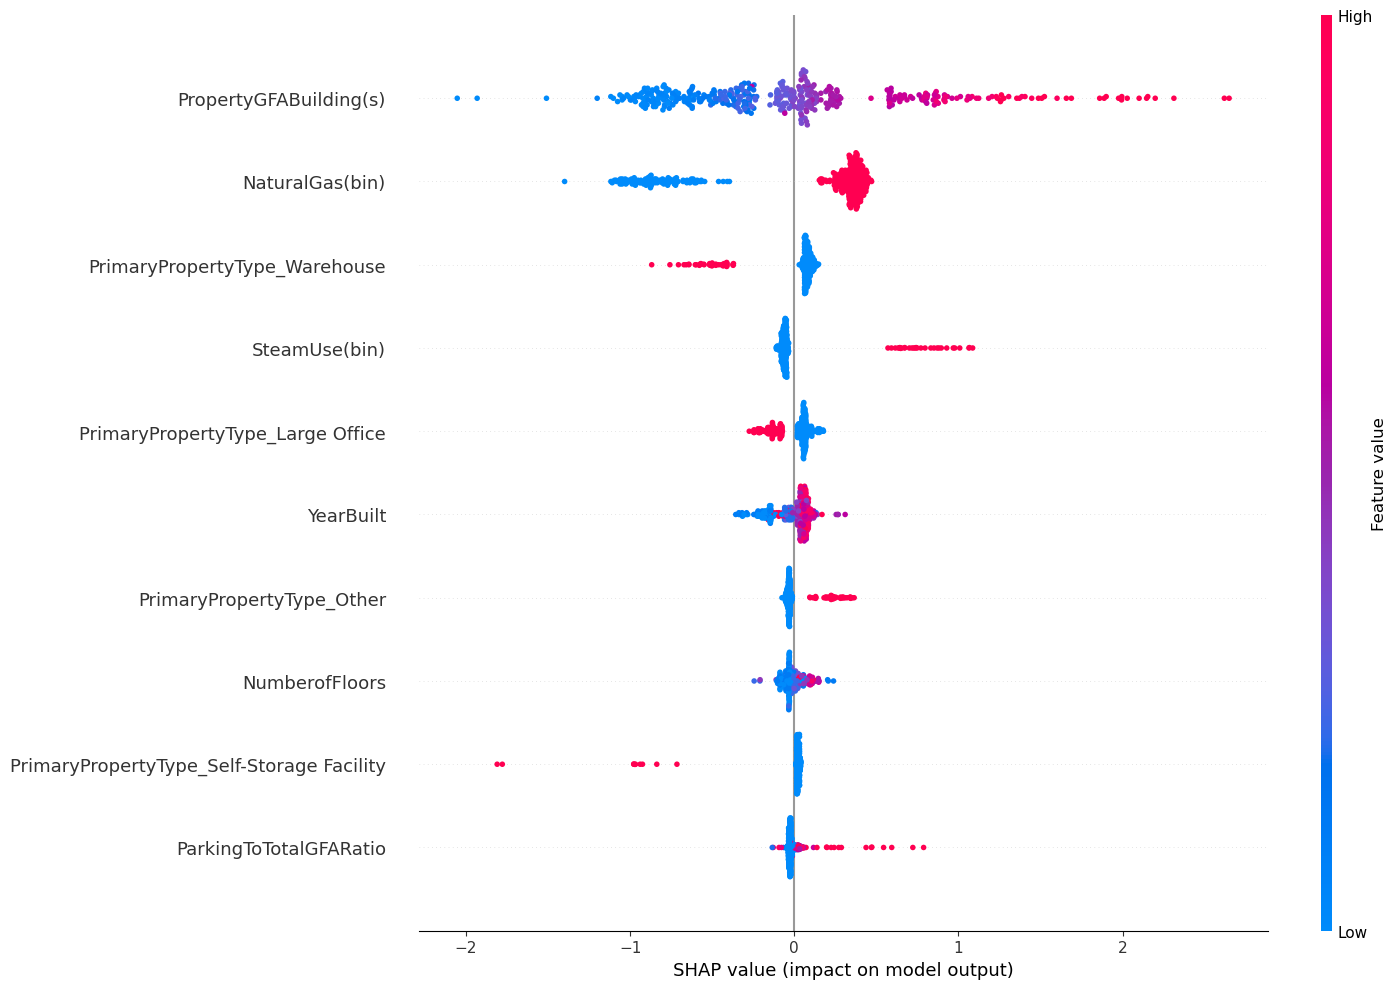

In [98]:
# Créer un objet explainer
#explainer = shap.TreeExplainer(reg)
explainer = shap.TreeExplainer(GradientBoost)

# Calculer les valeurs SHAP
shap_values = explainer.shap_values(X_test_std)

# Créer un graphique de barres pour l'importance des variables globale
shap.summary_plot(shap_values, feature_names=buildings_X.columns, max_display=10, features=X_test_std, plot_size=(15,10))

# <a name="C33">3.3 Importance des variables locale</a>

**Analyse de l’importance des variables locale sur le 1er individu du jeu de données**

In [99]:
# Créer un objet explainer
explainer = shap.TreeExplainer(GradientBoost)

# Calculer les valeurs SHAP pour un individu spécifique
#shap_values = explainer.shap_values(X_test_std.iloc[[0]])
shap_values = explainer.shap_values(X_test_std[[0]])

# Créer un graphique interactif pour l'importance des variables locale
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test_std[[0]], feature_names=buildings_X.columns)

# <a name="C4">Partie 4: Intégration d'EnergyStarScore</a>

L'EnergyStarScore est fastidieux à calculer avec l’approche utilisée actuellement par notre équipe. 

Intégrons cette variable à la modélisation pour évaluer son intéret.

Dans notre dataset, EnergyStarScore comporte environ 30% de valeurs manquantes

In [100]:
# import fichier CSV
buildings=pd.read_csv('buildings_before_modelisation.csv')

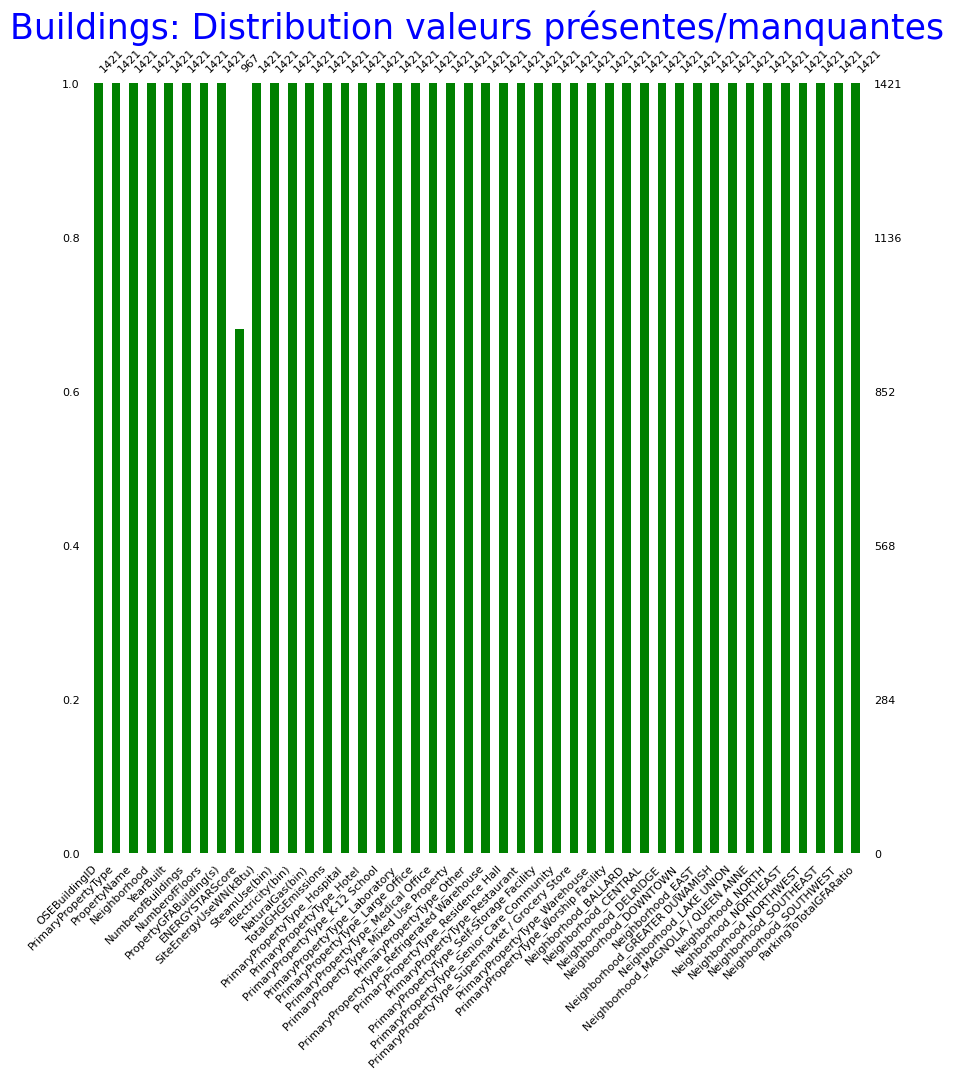

In [101]:
fig, ax = plt.subplots(figsize=(10,10))
msno.bar(buildings, color="green", ax=ax, fontsize=8)
ax.set_title("Buildings: Distribution valeurs présentes/manquantes")
ax.title.set_color('blue')
ax.title.set_size(25)
plt.show()

# <a name="C41">4.1 Entrainement du meilleur modèle avec EnergyStarScore</a>

In [102]:
# Suppression des individus ayant 'ENERGYSTARScore'=NaN
buildings=buildings.loc[~buildings['ENERGYSTARScore'].isna(),:]

In [103]:
# Suppression des target1 et target2 et des variables pas utiles pour la modélisation. On garde Energystarscore.
buildings_X=buildings.drop(columns=['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions','OSEBuildingID','PrimaryPropertyType','PropertyName','Neighborhood'])

# Transformation du dataframe buildings_X en matrice X
X=buildings_X.values

#X.shape

# Transformation en array numpy vecteur Y contenant la variable à prédire
#Y=buildings.loc[:,'SiteEnergyUseWN(kBtu)'].values #=> target1
Y=buildings.loc[:,'TotalGHGEmissions'].values #=> target2
#Y.shape

# Séparation des données en train/test
from sklearn import model_selection
X_train, X_test, y_train, y_test = \
	model_selection.train_test_split(X, Y,
                                	test_size=0.30, # 30% des données dans le jeu de test
                                	random_state=42) #permet d'avoir toujours les mêmes jeux de train et de test

# STANDARDISATION: Les données auront toutes une moyenne nulle et un écart type de 1
from sklearn.preprocessing import StandardScaler
std_scale = preprocessing.StandardScaler().fit(X_train) #calcul de la moyenne et l’écart type de X_train
X_train_std = std_scale.transform(X_train) #standardisation de X_train en utilisant la moyenne et l’écart type calculés à partir de X_train.
X_test_std = std_scale.transform(X_test) #standardisation de X_test en utilisant la moyenne et l’écart type calculés à partir de X_train.


In [121]:
params = {
    "n_estimators": 5000,
    "max_depth": 3,
    "min_samples_split": 10,
    "learning_rate": 0.003,
    "loss": "squared_error",
}

GradientBoosting2 = GradientBoostingRegressor(**params)
GradientBoosting2.fit(X_train_std, y_train)

GradientBoostingRegressor(learning_rate=0.003, min_samples_split=10,
                          n_estimators=5000)

In [122]:
y_pred_gboost2=GradientBoosting2.predict(X_test_std)

In [123]:
#Calcul de la RMSE (erreur quadratique moyenne)
RMSE_gboost2=np.sqrt( metrics.mean_squared_error(y_test, y_pred_gboost2) )
print("RMSE GBoost avec Energy Star Score: {:.2f}".format(RMSE_gboost2))

RMSE GBoost avec Energy Star Score: 0.67


In [124]:
# Calcul du coefficient de détermination R2
R2_gboost2 = metrics.r2_score(y_test, y_pred_gboost2)
print("R2 GradientBoost avec Energy Star Score: {:.2f}".format(R2_gboost2))

R2 GradientBoost avec Energy Star Score: 0.81


In [125]:
# Calcul de la MAE (mean_absolute_error)
MAE_gboost2 = metrics.mean_absolute_error(y_test, y_pred_gboost2)
print("MAE GradientBoost avec Energy Star Score: {:.2f}".format(MAE_gboost2))

MAE GradientBoost avec Energy Star Score: 0.51


# <a name="C42">4.2 Comparaison des résultats</a>

In [126]:
data2 = [['GradientBoosting', RMSE_gboost, R2_gboost, MAE_gboost],
         ['GradientBoosting with EnergyStarScore', RMSE_gboost2, R2_gboost2, MAE_gboost2]]

df = pd.DataFrame(data2, columns=['Algorithme', 'RMSE', 'R2', 'MAE'])
df

,Algorithme,RMSE,R2,MAE
0,GradientBoosting,0.775989,0.711243,0.597467
1,GradientBoosting with EnergyStarScore,0.672708,0.805607,0.512721


**L'intégration de l'Energy Star Score améliore nettement les performances du GradientBoosting**

# <a name="C43">4.3 Importance des variables globale</a>

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


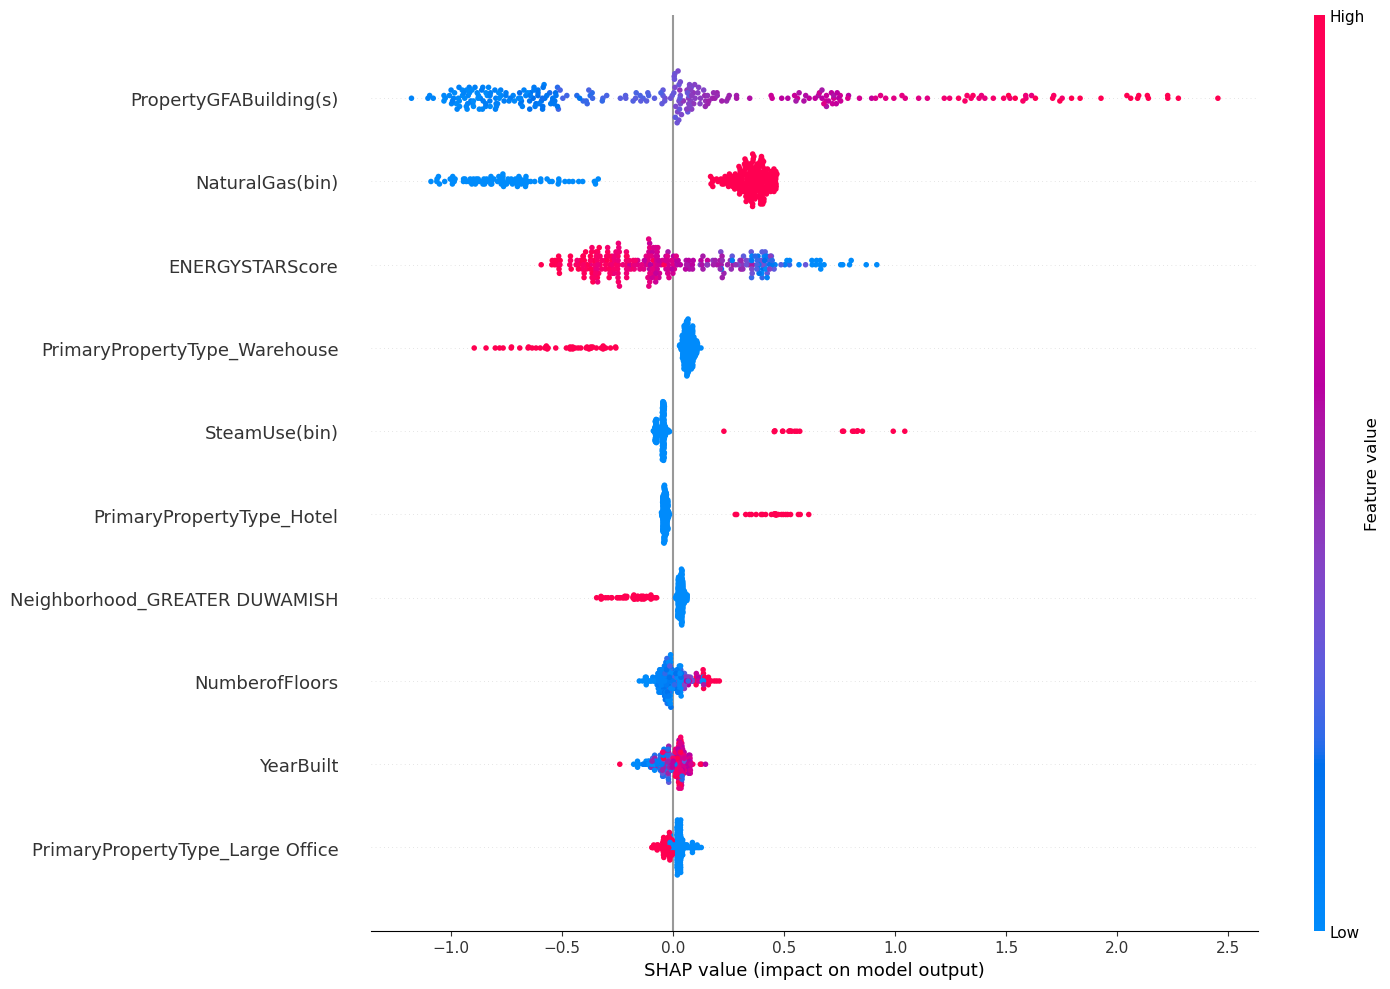

In [127]:
# Créer un objet explainer
#explainer = shap.TreeExplainer(reg)
explainer = shap.TreeExplainer(GradientBoosting2)

# Calculer les valeurs SHAP
shap_values = explainer.shap_values(X_test_std)

# Créer un graphique de barres pour l'importance des variables globale
shap.summary_plot(shap_values, feature_names=buildings_X.columns, max_display=10, features=X_test_std, plot_size=(15,10), title="AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA")

**L'Energy Star Score est la 3ème variable la plus importante après la surface des buildings et l'utilisation du gaz**